In [1]:
from PyLQR.sim import KDLRobot
from PyLQR.system import JointSpacePlannerSys, AngularKeypoint
from PyLQR.solver import BatchILQRCP, BatchILQR, ILQRRecursive
from PyLQR.utils import primitives, PythonCallbackMessage
import numpy as np

import matplotlib.pyplot as plt

# PyLQR: Joint space planner or tracker example

In this example, we will present how to use iLQR to plan or track a system that has for target space $\mathbf{\mu}_t$ :

* Joint state position $\mathbf{q}$

For state space $\mathbf{x}_t$ (it is a latent space):

* joint positions $\mathbf{q}$

$$
    \mathbf{x}_t = \lbrack \mathbf{q}^\top \rbrack^\top
$$

For command space $\mathbf{u}_t$:

* joint velocities $\mathbf{\dot{q}}$

$$
    \mathbf{u}_t = \lbrack \mathbf{\dot{q}}^\top \rbrack^\top
$$

<span style="color:red">**In this example there are no transformation between the target space and state space. To solve this solver iLQR is not needed (linear dynamics, quadratic cost), we use it with iLQR to showcase the use of this class with more complex objects (``SequentialSystem``)**</span>

In [2]:
# Global task variables
dof = 7
nb_state_var = dof # [q]
nb_ctrl_var = dof  # [dq)]
nb_fox_var = 7 # [q]
horizon=100
dt = 0.1

## Definition of the robot object

The first to do is to create the abstraction of the robot that we want to control. Here we will a robot's abstraction based on the KDL library. The ``KDLRobot`` class requires:

* An URDF file describing the robot that we want to use.
* The name of the base frame in the URDF
* The name of the tip frame in the URDF
* Initial joint configuration

This class will *simulate* the kinematics evolution of the Panda robot in function of the control command that we will send to him.

In [3]:
PATH_TO_URDF = "model.urdf"
BASE_FRAME = "panda_link0"
TIP_FRAME = "panda_tip"
q0 = [ 0.62991112, -0.2329776 , -0.01423721, -1.70254115,  0.06251303, # Initial joint configuration of the robot
        1.50592777,  0.71771416]
dq0 = [0]*dof

qMax = np.array([2.8973,1.7628,2.8973,-0.0698,2.8973,3.7525,2.8973])
qMin = np.array([-2.8973,-1.7628,-2.8973,-3.0718,-2.8973,-0.0175,-2.8973])
rbt = KDLRobot(PATH_TO_URDF,BASE_FRAME,TIP_FRAME,q0,dq0)

## Task & system definition

Now that we have an object simulating the kinematics of our robot, we have to build a system object that will describe the task that we want to perform. Here since we are looking to optimize position and orientation
we will instantiate an object of type ``JointSpacePlannerSys``. To create this object, we need:

* A list of Keypoints (here ``AngularKeypoint``), each element in this list represents a keypoint, it contains:
  * A Joint position target
  * A precision matrix
  * A discrete time value (discrete time of occurence)
* Joint limits/special end-effector transforms. Optional (see below).
* Some extra-information about the system:
  * Control command penalty (rfactor)
  * Horizon of the problem
  * Order of the system (in this example it's 1)
  * The discrete time step (dt)

In [4]:
target_1 = np.random.uniform(low=qMin,high=qMax,size=dof)
Qtarget1 = np.identity(dof)
target1_discrete_time = horizon//2 - 1
keypoint_1 = AngularKeypoint(target_1,Qtarget1,target1_discrete_time)

target_2 = np.random.uniform(low=qMin,high=qMax,size=dof)
Qtarget2 = np.identity(dof)
target2_discrete_time = horizon - 1
keypoint_2 = AngularKeypoint(target_2,Qtarget2,target2_discrete_time)

keypoints = [keypoint_1,keypoint_2]
cmd_penalties = [1e-5]*nb_ctrl_var
# It is not mandatory to set the limits, if you do not know them yet or do not want to use them. You can use this constructor:
# sys = PosOrnPlannerSys(rbt,keypoints,cmd_penalties,horizon,1,dt)
sys = JointSpacePlannerSys(rbt,keypoints,cmd_penalties,qMax,qMin,horizon,1,dt) 

## Solver definition

Now that the robot and system object are defined, we will define two different solvers to optimize the system:

* A Batch Iterative LQR with control primitives.
* A standard iLQR
* A standard batch iLQR

Because of the batch formulation, the first one can only be used as a planning algorithm. 
Seconde one can either be used as planning or tracking algorithm (by using either the resulting state sequences or the control gains).

Batch solution use a library of primitives to build the control command:

$$
    \mathbf{u} = \Psi \mathbf{w}
$$

Where $\mathbf{w}$ is the weight of each control primitives. To build the primitives, you can use the ``PyLQR.utils.primitives`` module.

In [5]:
u0_t = np.array([0]*(nb_ctrl_var))
u0 = np.tile(u0_t,horizon-1)

In [6]:
K = 2
psi = primitives.build_psi_unitstep(horizon-1,K)
PSI = np.kron(psi,np.identity(nb_ctrl_var))

In [7]:
Q = sys.get_Q_matrix(False)

In [8]:
mu = sys.get_mu_vector(False)

In [9]:
u0_t = np.array([0]*(nb_ctrl_var-1) + [0])
u0 = np.tile(u0_t,horizon-1)

K = 2
psi = primitives.build_psi_unitstep(horizon-1,K)
PSI = np.kron(psi,np.identity(nb_ctrl_var))

# For the batch solution, if you want to use of diagonal elements for Q or special construction of mu,
# you can override targets and precisions set in the system by replacing the 2 lines below by what you want.
mu = sys.get_mu_vector(False)
Q = sys.get_Q_matrix(False)

planner1 = BatchILQRCP(sys,PSI)
planner2 = ILQRRecursive(sys)
planner3 = BatchILQR(sys)

In [10]:
cb = PythonCallbackMessage() # callback to notify python code of the solver evolution

In [11]:
%%time
U1 = planner1.solve(10,u0,True,cb)
U1 = U1.reshape((horizon-1,nb_ctrl_var))
rbt.set_conf(q0,dq0,True)
X1 = np.zeros((horizon,nb_state_var))
F_X1 = np.zeros((horizon,nb_fox_var))

X1[0] = rbt.get_q()
F_X1[0] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn()))

for i in range(horizon-1):
    ut = U1[i]
    
    rbt.send_vel(dt,ut,True)
    
    X1[i+1] = rbt.get_q()
    F_X1[i+1] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn() ))

Iteration 1, Cost: 44.73, alpha= 1
Iteration 2, Cost: 0.020105, alpha= 1
Iteration 3, Cost: 0.00149855, alpha= 1
Iteration 4, Cost: 0.00149047, alpha= 1
CPU times: user 27.5 ms, sys: 37 µs, total: 27.6 ms
Wall time: 26 ms


In [15]:
%%time
X2,F_X2,U2,K2,k2,cost = planner2.solve(u0.reshape((-1,nb_ctrl_var)),10,True,True,cb)

Iteration 1, Cost: 1.70048e-05, alpha= 1, time= 0.00273181
Iteration 2, Cost: 1.70075e-05, alpha= 0.000976562, time= 0.0102201
CPU times: user 16.7 ms, sys: 328 µs, total: 17 ms
Wall time: 16.2 ms


In [16]:
%%time
U3 = planner3.solve(10,u0,True,cb)
U3 = U3.reshape((horizon-1,nb_ctrl_var))
rbt.set_conf(q0,dq0,True)
X3 = np.zeros((horizon,nb_state_var))
F_X3 = np.zeros((horizon,nb_fox_var))

X3[0] = rbt.get_q()
F_X3[0] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn()))

for i in range(horizon-1):
    ut = U3[i]
    
    rbt.send_vel(dt,ut,True)
    
    X3[i+1] = rbt.get_q()
    F_X3[i+1] = np.hstack((rbt.get_ee_pos(), rbt.get_ee_orn() ))

Iteration 1, Cost: 44.73, alpha= 1
Iteration 2, Cost: 0.00144987, alpha= 0.015625
CPU times: user 203 ms, sys: 11.9 ms, total: 215 ms
Wall time: 213 ms


<IPython.core.display.Javascript object>


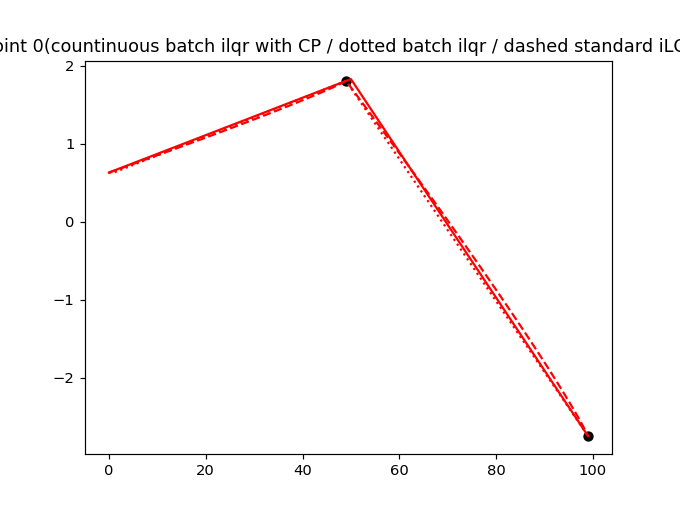

<IPython.core.display.Javascript object>


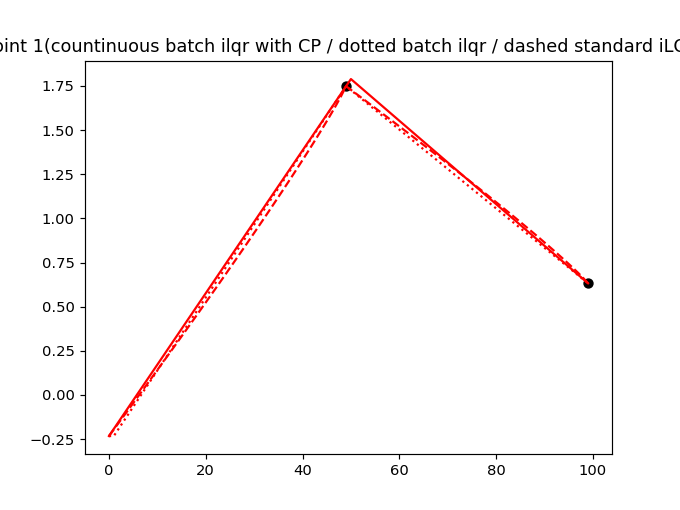

<IPython.core.display.Javascript object>


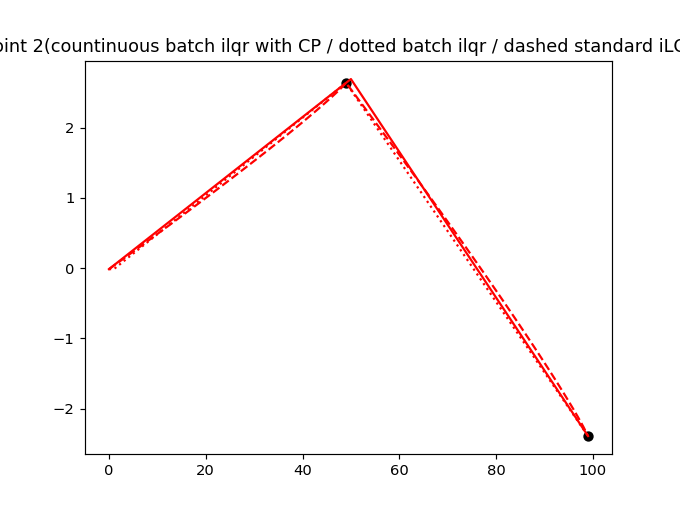

<IPython.core.display.Javascript object>


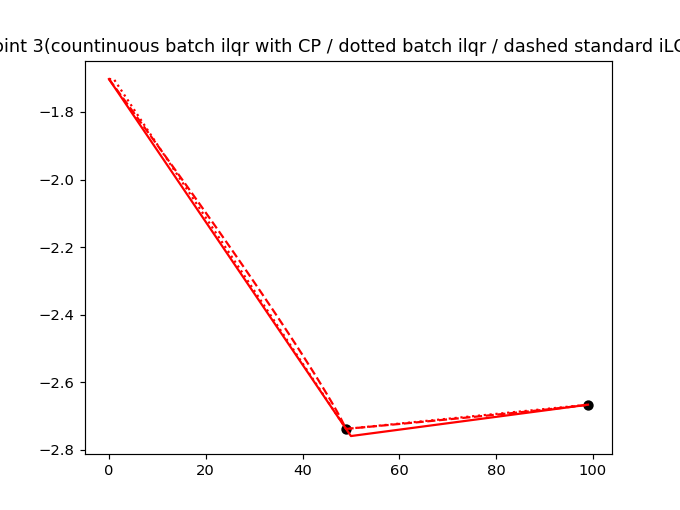

<IPython.core.display.Javascript object>


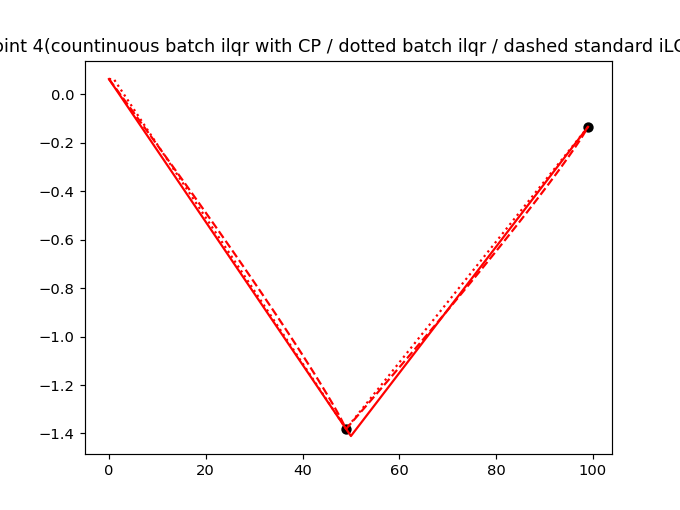

<IPython.core.display.Javascript object>


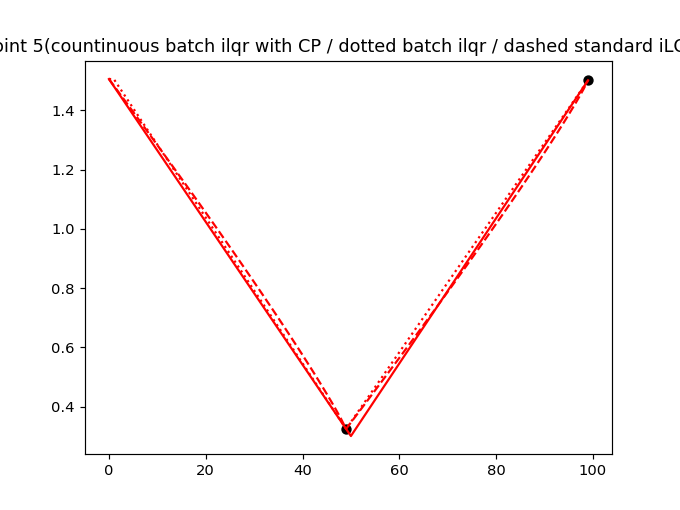

<IPython.core.display.Javascript object>


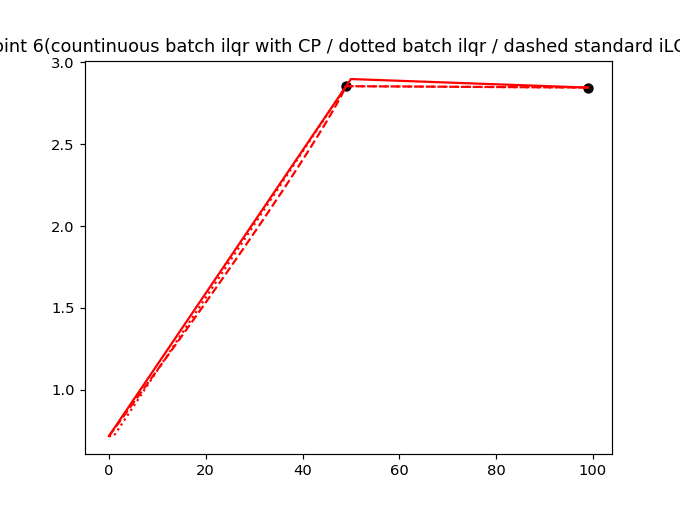

In [17]:
%matplotlib notebook
X2 = np.asarray(X2)

for i in range(dof):
    plt.figure()
    plt.title("Joint "+str(i)+"(countinuous batch ilqr with CP / dotted batch ilqr / dashed standard iLQR)")
    
    plt.plot(X1[:,i],c="red")
    plt.plot(X2[:,i],c="red",linestyle="dashed")
    plt.plot(X3[:,i],c="red",linestyle="dotted")
    
    plt.scatter(target1_discrete_time,target_1[i],c="black")
    plt.scatter(target2_discrete_time,target_2[i],c="black")

**As you can see, both solvers gave a good result, for this kind of example an advantage has to be given to the standard iLQR solver that performs much more faster than batch solution. The reason behind that is that time complexity evolves exponentially with horizon for the batch formulation. Also in this example we set the targets to uniformally spread the horizon (to not have problems with control primitives), but it is not mandatory if you are using the standard iLQR solution**